<a href="https://colab.research.google.com/github/Linsen-gao-457/AutoTune-TR/blob/main/AutoTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ray

In [36]:
!pip install tabulate

In [40]:
import os
import pickle
import tempfile
from pathlib import Path
from functools import partial
from tabulate import tabulate
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

from ray import train, tune
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

In [3]:
def load_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform
    )

    return trainset, testset

In [4]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [20]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
class SubsampledTrustRegion:
    def __init__(self, parameters, lr, radius=0.01):
        self.parameters = list(parameters)
        self.lr = lr
        self.radius = radius
        self.internal_state = {}
    def step(self, loss):
        self.zero_grad()

        grads = torch.autograd.grad(loss, self.parameters, create_graph=True)

        for p, g in zip(self.parameters, grads):
            if g is None:
                continue

            hvp = torch.autograd.grad(
                outputs=g, inputs=p, grad_outputs=g.detach(), retain_graph=True
            )[0]

            denom = hvp.norm() + 1e-6
            step = -self.lr * g / denom
            step = step.clamp(min=-self.radius, max=self.radius)

            with torch.no_grad():
              p.data = p.data + step


    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

    def state_dict(self):
        return {"lr": self.lr, "internal_state": self.internal_state}

    def load_state_dict(self, state_dict):
        self.lr = state_dict.get("lr", self.lr)
        self.radius = state_dict.get("radius", self.radius)


In [30]:
def train_cifar(config, data_dir=None):
    print(f"Launching trial with config: {config}")
    torch.autograd.set_detect_anomaly(True)
    net = Net(config["l1"], config["l2"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()

    if config["optimizer"] == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "tr":
        optimizer = SubsampledTrustRegion(net.parameters(), lr=config["lr"])
    else:
        raise ValueError(f"Unknown optimizer: {config['optimizer']}")

    checkpoint = train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            if config["optimizer"] == "sgd":
                optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainset, testset = load_data(data_dir)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_subset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=2)

    for epoch in range(start_epoch, 10):
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            if config["optimizer"] == "tr":
                optimizer.step(loss)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / epoch_steps))
                running_loss = 0.0

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)
            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report({"loss": val_loss / val_steps, "accuracy": correct / total}, checkpoint=checkpoint)
    print("Finished Training")

In [34]:
def evaluate_best_trials(result, data_dir, gpus_per_trial=0):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    for optimizer in ["sgd", "tr"]:
        print(f"\nEvaluating best model for optimizer: {optimizer}")
        trials = [t for t in result.trials if t.config["optimizer"] == optimizer and t.last_result is not None]
        if not trials:
            print(f"No completed trials for optimizer {optimizer.upper()}")
            continue
        trial = max(trials, key=lambda t: t.last_result["accuracy"])
        model = Net(trial.config["l1"], trial.config["l2"])
        if gpus_per_trial > 1:
            model = nn.DataParallel(model)
        model.to(device)

        checkpoint = result.get_best_checkpoint(trial=trial, metric="accuracy", mode="max")
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                data = pickle.load(fp)
            model.load_state_dict(data["net_state_dict"])

        test_acc = test_accuracy(model, device)
        print(f"Test accuracy for {optimizer.upper()}: {test_acc:.4f}")

def main(num_samples=2, max_num_epochs=10, gpus_per_trial=0):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    search_space = []
    for i in range(num_samples):
        optimizer = "tr" if i < num_samples // 2 else "sgd"
        search_space.append({
            "l1": tune.choice([2**i for i in range(9)]),
            "l2": tune.choice([2**i for i in range(9)]),
            "lr": tune.loguniform(1e-3, 1e-1),
            "batch_size": tune.choice([2, 4, 8, 16]),
            "optimizer": optimizer
        })

    scheduler = ASHAScheduler(metric="loss", mode="min", max_t=max_num_epochs, grace_period=1, reduction_factor=2)

    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=tune.grid_search(search_space),
        scheduler=scheduler,
    )

    evaluate_best_trials(result, data_dir, gpus_per_trial)

if __name__ == "__main__":
    main(num_samples=2, max_num_epochs=1, gpus_per_trial=0)

2025-04-23 02:53:49,163	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2025-04-23_02-53-49   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 2                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2025-04-23_02-53-49

Trial status: 2 PENDING
Current time: 2025-04-23 02:53:49. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------+
| Trial name                status   |
+------------------------------------+
| train_cifar_2e850_00000   PENDING  |
| train_cifar_2e850_00001   PENDING  |
+------------------------------------+
Trial status: 2 PENDING
Current ti

(func pid=20558) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_02-53-49/train_cifar_2e850_00000_0_config=l1_32_l2_128_lr_0_0650669723793539_batch_size_16_optimizer_tr,batch_size=16,l1=32,l2=128,lr=0.065_2025-04-23_02-53-49/checkpoint_000000)



Trial train_cifar_2e850_00001 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_2e850_00001 config             |
+--------------------------------------------------+
| batch_size                                     4 |
| l1                                            64 |
| l2                                           256 |
| lr                                       0.00141 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=21122) Launching trial with config: {'l1': 64, 'l2': 256, 'lr': 0.0014064537689724547, 'batch_size': 4, 'optimizer': 'sgd'}
(func pid=21122) [1,  2000] loss: 2.114

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-04-23 02:59:50. Total running time: 6min 0s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name        

2025-04-23 03:00:53,729	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_cifar_2025-04-23_02-53-49' in 0.0054s.



Trial train_cifar_2e850_00001 finished iteration 1 at 2025-04-23 03:00:53. Total running time: 7min 4s
+-------------------------------------------------------------+
| Trial train_cifar_2e850_00001 result                        |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000000 |
| time_this_iter_s                                    86.5833 |
| time_total_s                                        86.5833 |
| training_iteration                                        1 |
| accuracy                                             0.4797 |
| loss                                     1.4405957460403442 |
+-------------------------------------------------------------+
Trial train_cifar_2e850_00001 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2025-04-23_02-53-49/train_cifar_2e850_00001_1_config=l1_64_l2_256_lr_0_0014064537689724547_batch_size_4_optimizer_sgd,batch_size=4,l1=64,l2=256,lr=0.0

(func pid=21122) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_02-53-49/train_cifar_2e850_00001_1_config=l1_64_l2_256_lr_0_0014064537689724547_batch_size_4_optimizer_sgd,batch_size=4,l1=64,l2=256,lr=0.0_2025-04-23_02-53-49/checkpoint_000000)


Test accuracy for SGD: 0.4810

Evaluating best model for optimizer: tr
Test accuracy for TR: 0.3463


2025-04-23 03:33:55,759	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2025-04-23_03-33-55   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 4                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2025-04-23_03-33-55

Trial status: 4 PENDING
Current time: 2025-04-23 03:33:55. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------+
| Trial name                status   |
+------------------------------------+
| train_cifar_c8f66_00000   PENDING  |
| train_cifar_c8f66_00001   PENDING  |
| train_cifar_c8f66_00002   PENDING  |
| train_cifar_c8f66_00003   PENDIN

(func pid=30820) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_03-33-55/train_cifar_c8f66_00000_0_config=l1_8_l2_4_lr_0_01926453916175792_batch_size_4_optimizer_tr,batch_size=4,l1=8,l2=4,lr=0.0193_2025-04-23_03-33-55/checkpoint_000000)



Trial status: 1 TERMINATED | 3 PENDING
Current time: 2025-04-23 03:38:26. Total running time: 4min 30s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c8f66_00000   TERMINATED        1             259.95   2.01458       0.2611 |
| train_cifar_c8f66_00001   PENDING                                                       |
| train_cifar_c8f66_00002   PENDING                                                       |
| train_cifar_c8f66_00003   PENDING                                                       |
+-----------------------------------------------------------------------------------------+

Trial train_cifar_c8f66_00001 started with configuration:
+-------------------------

(func pid=32007) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_03-33-55/train_cifar_c8f66_00001_1_config=l1_16_l2_128_lr_0_001745316421670363_batch_size_8_optimizer_tr,batch_size=8,l1=16,l2=128,lr=0.001_2025-04-23_03-33-55/checkpoint_000000)



Trial train_cifar_c8f66_00002 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c8f66_00002 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                            64 |
| l2                                             1 |
| lr                                       0.00218 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=32775) Launching trial with config: {'l1': 64, 'l2': 1, 'lr': 0.0021773486700144107, 'batch_size': 8, 'optimizer': 'sgd'}

Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-04-23 03:41:26. Total running time: 7min 30s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter  

(func pid=32775) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_03-33-55/train_cifar_c8f66_00002_2_config=l1_64_l2_1_lr_0_0021773486700144107_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=1,lr=0.0022_2025-04-23_03-33-55/checkpoint_000000)



Trial train_cifar_c8f66_00003 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c8f66_00003 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| l1                                           128 |
| l2                                             2 |
| lr                                       0.01116 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=33106) Launching trial with config: {'l1': 128, 'l2': 2, 'lr': 0.011164589742322435, 'batch_size': 16, 'optimizer': 'sgd'}

Trial status: 3 TERMINATED | 1 RUNNING
Current time: 2025-04-23 03:42:26. Total running time: 8min 30s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total ti

2025-04-23 03:42:43,770	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_cifar_2025-04-23_03-33-55' in 0.0061s.



Trial train_cifar_c8f66_00003 finished iteration 1 at 2025-04-23 03:42:43. Total running time: 8min 47s
+-------------------------------------------------------------+
| Trial train_cifar_c8f66_00003 result                        |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000000 |
| time_this_iter_s                                   34.45031 |
| time_total_s                                       34.45031 |
| training_iteration                                        1 |
| accuracy                                             0.3298 |
| loss                                     1.7293347120285034 |
+-------------------------------------------------------------+
Trial train_cifar_c8f66_00003 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2025-04-23_03-33-55/train_cifar_c8f66_00003_3_config=l1_128_l2_2_lr_0_011164589742322435_batch_size_16_optimizer_sgd,batch_size=16,l1=128,l2=2,lr=0.0

(func pid=33106) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_03-33-55/train_cifar_c8f66_00003_3_config=l1_128_l2_2_lr_0_011164589742322435_batch_size_16_optimizer_sgd,batch_size=16,l1=128,l2=2,lr=0.01_2025-04-23_03-33-55/checkpoint_000000)


Test accuracy for SGD: 0.3284

Evaluating best model for optimizer: tr
Test accuracy for TR: 0.2877

+--------------+------------+------+------+---------+--------------+--------+------------+--------+------------+
| Trial name   | status     |   l1 |   l2 |      lr |   batch_size |   iter |   time (s) |   loss |   accuracy |
+==============+============+======+======+=========+==============+========+============+========+============+
| c8f66_00000  | TERMINATED |    8 |    4 | 0.01926 |            4 |      1 |      259.9 | 2.0146 |     0.2611 |
+--------------+------------+------+------+---------+--------------+--------+------------+--------+------------+
| c8f66_00001  | TERMINATED |   16 |  128 | 0.00175 |            8 |      1 |      157.4 | 1.9558 |     0.2797 |
+--------------+------------+------+------+---------+--------------+--------+------------+--------+------------+
| c8f66_00002  | TERMINATED |   64 |    1 | 0.00218 |            8 |      1 |       52.8 | 2.303  |     0.09

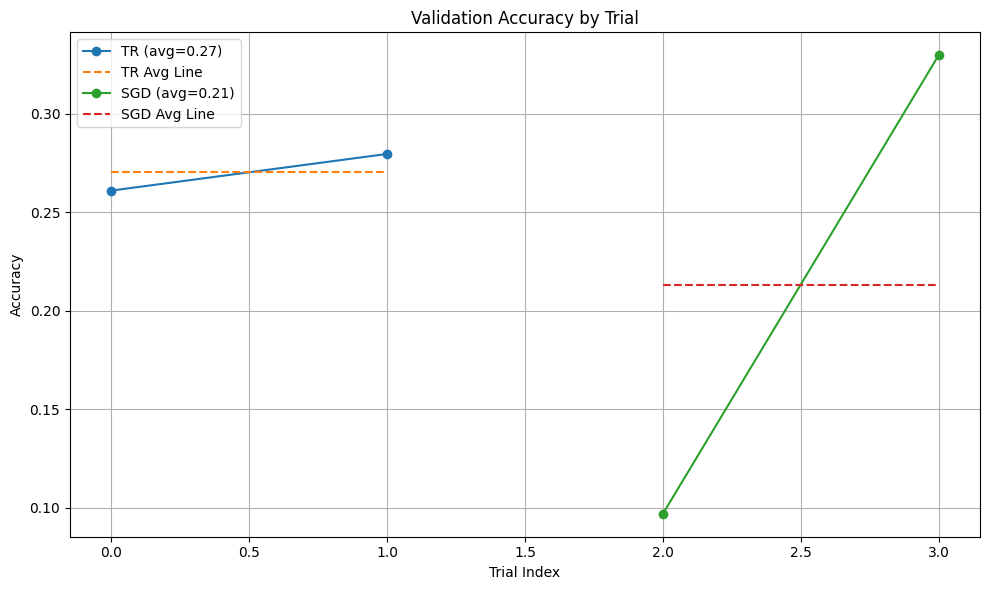

In [42]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ray import tune
from ray.tune import Trainable, CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint
import pickle
import os
import tempfile
from pathlib import Path
from tabulate import tabulate
from functools import partial
import pandas as pd

def evaluate_best_trials(result, data_dir, gpus_per_trial=0):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    accuracies = {}
    trial_data = []

    for optimizer in ["sgd", "tr"]:
        print(f"\nEvaluating best model for optimizer: {optimizer}")
        trials = [t for t in result.trials if t.config["optimizer"] == optimizer and t.last_result is not None]
        if not trials:
            print(f"No completed trials for optimizer {optimizer.upper()}")
            continue
        trial = max(trials, key=lambda t: t.last_result["accuracy"])
        model = Net(trial.config["l1"], trial.config["l2"])
        if gpus_per_trial > 1:
            model = nn.DataParallel(model)
        model.to(device)

        checkpoint = result.get_best_checkpoint(trial=trial, metric="accuracy", mode="max")
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                data = pickle.load(fp)
            model.load_state_dict(data["net_state_dict"])

        test_acc = test_accuracy(model, device)
        accuracies[optimizer.upper()] = test_acc
        print(f"Test accuracy for {optimizer.upper()}: {test_acc:.4f}")

    # Print table of all trials
    headers = ["Trial name", "status", "l1", "l2", "lr", "batch_size", "iter", "time (s)", "loss", "accuracy"]
    rows = []
    for trial in result.trials:
        config = trial.config
        result_data = trial.last_result if trial.last_result else {}
        rows.append([
            trial.trial_id,
            trial.status,
            config.get("l1", "-"),
            config.get("l2", "-"),
            f"{config.get('lr', 0):.5f}",
            config.get("batch_size", "-"),
            result_data.get("training_iteration", "-"),
            f"{result_data.get('time_total_s', 0):.1f}" if result_data else "-",
            f"{result_data.get('loss', 0):.4f}" if result_data else "-",
            f"{result_data.get('accuracy', 0):.4f}" if result_data else "-",
        ])
    print("\n" + tabulate(rows, headers=headers, tablefmt="grid"))

    return pd.DataFrame([
        {
            "trial_id": t.trial_id,
            "optimizer": t.config.get("optimizer", "-"),
            "accuracy": t.last_result.get("accuracy", 0) if t.last_result else 0
        }
        for t in result.trials if t.last_result is not None
    ])

def plot_results(trial_data):
    if not trial_data.empty:
        plt.figure(figsize=(10, 6))

        for opt in trial_data["optimizer"].unique():
            subset = trial_data[trial_data["optimizer"] == opt].sort_index()
            plt.plot(subset.index, subset["accuracy"], marker='o', label=f"{opt.upper()} (avg={subset['accuracy'].mean():.2f})")
            avg_line = [subset["accuracy"].mean()] * len(subset)
            plt.plot(subset.index, avg_line, linestyle='--', label=f"{opt.upper()} Avg Line")

        plt.title("Validation Accuracy by Trial")
        plt.xlabel("Trial Index")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

def main(num_samples=2, max_num_epochs=10, gpus_per_trial=0):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    search_space = []
    for i in range(num_samples):
        optimizer = "tr" if i < num_samples // 2 else "sgd"
        search_space.append({
            "l1": tune.choice([2**i for i in range(9)]),
            "l2": tune.choice([2**i for i in range(9)]),
            "lr": tune.loguniform(1e-3, 1e-1),
            "batch_size": tune.choice([2, 4, 8, 16]),
            "optimizer": optimizer
        })

    scheduler = ASHAScheduler(metric="loss", mode="min", max_t=max_num_epochs, grace_period=1, reduction_factor=2)

    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=tune.grid_search(search_space),
        scheduler=scheduler,
    )

    trial_data = evaluate_best_trials(result, data_dir, gpus_per_trial)
    plot_results(trial_data)

if __name__ == "__main__":
    main(num_samples=4, max_num_epochs=1, gpus_per_trial=0)
